In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Lecture 24:

- Find out about Machine Learning
- Learn about using the **scikit-learn** python package for clustering analysis.
- Apply clustering analysis to Earth Science problems

In the next couple of lectures, we are going to learn how to use the **scikit-learn** package to perform some machine learning techniques.

### What is machine learning anyway?

Machine Learning is one of those buzzwords you seem to hear all over the place these days, but what does it actually mean?

At it's simplest, machine learning is a way of finding 'features' in and assigning 'labels' to your data that allow you to build models.

There are two main types of machine learning, _supervised_ and _unsupervised_. 

_Supervised_ machine learning involves labeling a subset of your data and fitting a known type of model to explain these labels. The computer then applies this model to new data and can label the new data automatically. The labels you apply to data can be a continuous set of values,  known as _regression_ or they can be discrete, known as _classification. 

We're all pretty familiar with supervised machine learning already. Every time you try to log into a website and you have to click on pictures of cars or road signs to log in, you're teaching Google how to recognise those objects in images. Google then uses those data to create models that it uses to teach its self driving cars how to 'see', for example. 

_Unsupervised_ machine learning is fundamentally different because it can be applied to a dataset without training it first. This type of learning looks for features in the dataset that it can use to categorize different parts of the data (known as _clustering_) or define a coordinate space to help see the data, better known as (_dimensionality reduction_).

This all might seem quite confusing and abstract right now, but with the examples below you should start to get an idea of what you can use machine learning for. This lecture is just a small fraction of what can be done.  If you want to really learn how to do it, start with this book: https://jakevdp.github.io/PythonDataScienceHandbook/  It is like this class, in that it is a bunch of Jupyter notebooks which now you are a pro at. 

Today we are going to use a form of unsupervised learning (clustering) to do some geology!.

### The Orocopio Mountains Dataset
The dataset poles_data contains a dataset of poles to bedding planes from the Orocopio mountains. We learned about poles to planes in Lecture 22. If a rock is composed of sediments that are layed down flat on top of one another, then we would expect the pole to the plane to be vertical (because the plane itself is horizontal). If instead the plane is tilted, we might expect the pole to the plane to be in some other direction. Let's peek at a data set of poles from bedding planes measured in the  Orocopio Mountains.

In [2]:
poles_data=pd.read_csv('Datasets/Orocopio_Poles_Data.csv')
poles_data.head()

,Lon,Lat,Pole_Az,Pole_Plunge
0,-115.684573,33.547327,340.0,13.0
1,-115.684341,33.547283,359.0,14.0
2,-115.684341,33.547283,347.0,11.0
3,-115.685112,33.547408,332.0,13.0
4,-115.685650,33.547545,12.0,32.0


We can use a modified version of our equal area plot to plot the 'Pole_Az' and 'Pole Plunge' columns on an equal area projection to see what the bedding planes look like.

In [27]:
# Here's the equal angle function
EqualArea = lambda Pl: np.sqrt(2.)*90.*np.sin(np.radians(90.-Pl)/(2.))

def plot_equal_area(Azs,Pls,colors='black',cmap='RdBu',alpha=1):
    """
    Plots an Equal Angle plot for data d, colors are a string or list of colors
    to be passed to the points in data
    Note that this is different to the code in lecture 20 because it uses a
    scatter plot.
    
    Parameters:
    ____________
        Azs : np.array
            Azimuths of poles to planes
        Pls : np.array
            Plunges of poles to planes
            
    Returns:
    _________
        None
             
    """
    fig = plt.subplot(111, polar=True) 
    # set the coordinates (like for rose diagrams)
    fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
    fig.set_theta_zero_location("N") # Specify 0-degrees as North
    # for this we want the full 90 degrees, so set the scale
    plt.polar([0],[90]) ## to scale grid
    # plot the first direction as a red dot
    fig.scatter(np.radians(Azs),(EqualArea(Pls)),c=colors,cmap=cmap,alpha=alpha)
    # plot the second direction as a blue square

    # make a list of contours to plot
    # notice use of list comprehension
    # label the azimuths at 20 degree intervals
    AzContours=range(0,360,20)
    AzLabels=[str(p) for p in AzContours]
    plt.thetagrids(AzContours,AzLabels)
    # and now the plunges
    PlContours=[EqualArea(a) for a in range(10,90,20)] ##don't include center or edge
    # make a list of labels
    PlLabels=[str(a) for a in range(10,90,20)]
    # draw on the plunge contours and label them
    plt.rgrids(PlContours,PlLabels)
    # label the plot
    plt.title('Equal Area Net');

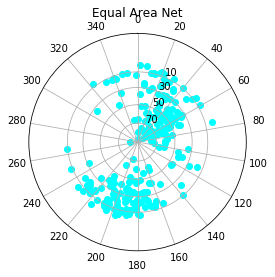

In [28]:
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors='cyan')

This is interesting! It seems that there are two 'clusters' with of bedding planes in different directions in this dataset, one to the north-east and one to the south-west. We want a way of separating these two clusters, but first let's think about what causes this. Is there some spatial relationship between where the different directions are found?

#### Quiver Plots and **plt.imshow( )**

To illustrate this we can use a type of plot known as a 'quiver plot'.  We will learn more about quiver plots in later lectures.  But for now, it draws an arrow with the direction of the plane on a plot. To do this, we need to convert the data from azimuth and plunge to x, y and z. We have the handy function **dir2cart( )** which we already know about.  

In [12]:
def dir2cart(Az,Pl):
    """
    converts polar directions to cartesian coordinates
    Inputs: 
        Dir[Azimuth,Plunge]:  directions in degreess
    Output:
        [X,Y,Z]: cartesian coordinates
    """
    Az=np.radians(Az)
    Pl=np.radians(Pl)
    return [np.cos(Az)*np.cos(Pl),np.sin(Az)*np.cos(Pl),np.sin(Pl)]

In [13]:
u,v,w=dir2cart(poles_data.Pole_Az.values,poles_data.Pole_Plunge.values)

In our coordinate system, $w$ is straight up, so planes with a steeper direction will have a smaller $u$ and $v$ components and a larger $w$ component, and so the arrows on the quiver plot will appear shorter in length.  

We will plot the quiver plot on top of a satellite image of the area, using the **plt.imread( )** and **plt.imshow( )** functions in **matplotlib**. These take an image and convert it into a coordinate system we can plot data onto.

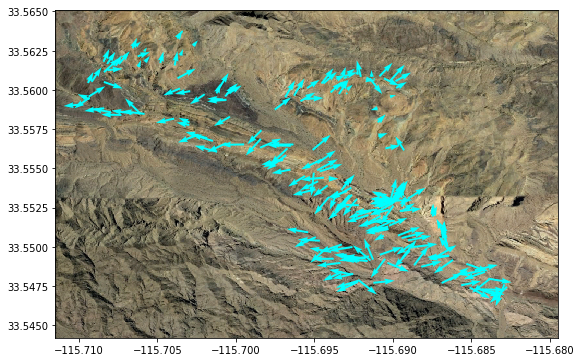

In [16]:
img = plt.imread('Datasets/GoogleEarthImage.png') #Reads in our image as a numpy array
extent = [-115.7115, -115.6795, 33.5442, 33.5651] #Sets the corners of the image in lat/lon for plotting
plt.figure(figsize=(9,13)) #Creates a new figure object to put the image on
plt.imshow(img, origin='upper', extent=extent) #Plots the satellite image.;

#Now let's plot the quivers onto the image 
#plt.quiver takes 4 arguments, x and y (locations of arrows), 
# and u and v (lengths of arrows in u and v directions).  
# We can also set the color so we can see the vectors better

plt.quiver(poles_data.Lon,poles_data.Lat,u,v,color='cyan');

This plot tells us an interesting story. Along the center of the satellite image runs a linear feature. To the north of this feature, we see that the arrows are pointing to the north-east. To the south-west of this image, the arrows are pointing south-west. What could be the cause of this pattern?

One probable cause would be a fold or anticline. For an illustration, see the image below. In an anticline, the horizontal layers are tilted away from the axis of the fold, so that the poles to the plane (arrows) are pointing away from the fold axis (dotted line). 

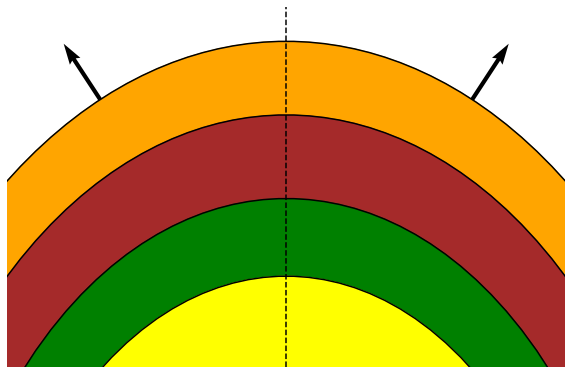

In [4]:
Image('Figures/Fold_Diagram.png',width=300)

#### Clustering our data
Instead of "eyeballing" as we did at first, what if we wanted to automatically sort the two different directions into two different groups? How would we most easily do that? We don't really want to have to _train_ this dataset as we don't really care which group is which in this case, we just want some way of splitting the data into sensible groups. As such we might want to use some kind of _unsupervised_ machine learning process.

The **scikit-learn** package has a module called **sklearn.cluster** that allows us to solve this problem. There are many algorithms for different 'shapes' of clusters. Let's try converting our data into a format **scikit-learn** understands, then use the **Kmeans** clustering algorithm on them.

Remember from Lecture 16, that **scikit-learn** requires our data to be in a format in which  each datapoint has a set of _features_ which are a bit like coordinates.

In [21]:
input_data=np.array([poles_data.Pole_Az,poles_data.Pole_Plunge]).T
print(input_data[0:5])

[[340.  13.]
 [359.  14.]
 [347.  11.]
 [332.  13.]
 [ 12.  32.]]


Now let's do the clustering:

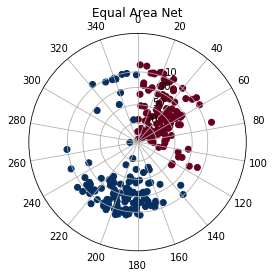

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2) #This tells us that we are using a clustering algorithm with 2 clusters

fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers)

Hmm, it seems like this didn't work exactly as expected. Notice how there seems to be a change in cluster across the 0 degree Azimuth line? Let's plot Azimuth against plunge on an x,y plot to see why this didn't seem to work very well. 

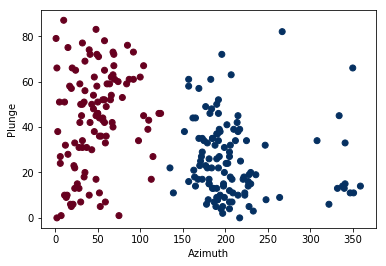

In [30]:
plt.scatter(poles_data.Pole_Az,poles_data.Pole_Plunge,c=clusternumbers,cmap='RdBu');
plt.xlabel('Azimuth')
plt.ylabel('Plunge');

The **Kmeans** algorithm treats data as if they were cartesian. But in geology, we often use directions that go from 0 to 360 which doesn't behave the same way as other cartesian data sets.  For example,an azimuth of 340 is closer to 200 than to 0 under this scheme. A simple solution to this would be to convert our azimuths and plunges to cartesian coordinates (as we did for the quiver plot) before clustering. Let's try again:

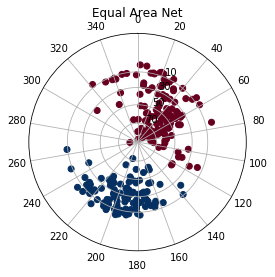

In [31]:
kmeans = KMeans(n_clusters=2) #This tells us that we are using a clustering algorithm 
# with 2 clusters
input_data=np.array([u,v,w]).transpose() # make and array with u,v,w as the first, second and third rows
fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers)

Much better! Let's see how it looks on the satellite image!

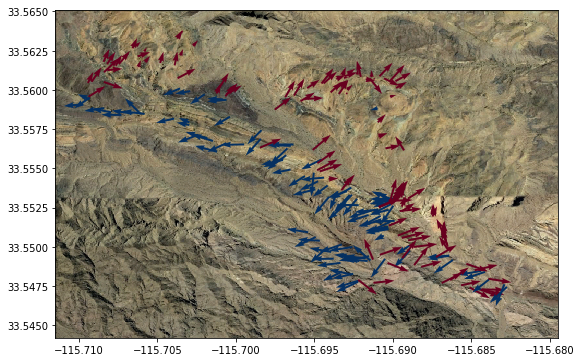

In [33]:
import matplotlib.pyplot as plt
extent = [-115.7115, -115.6795, 33.5442, 33.5651]
img = plt.imread('Datasets/GoogleEarthImage.png')
plt.figure(figsize=(9,13))
plt.imshow(img, origin='upper', extent=extent)
plt.quiver(poles_data.Lon,poles_data.Lat,u,v,clusternumbers,cmap='RdBu'); #5th argument controls arrow color

Really cool.  It seems that there's something a bit more complicated going on here than just a single fold axis going down the middle, but we can see the broad trend and could probably even draw the axis in a lot of places now.
One final thing to note with **Kmeans**; you are not required  to choose the number of clusters.  However letting it work on its own generally doesn't work too well as it will try to find clusters with very similar sizes. If we try it with this example, we get a lot of clusters which don't really tell us much.

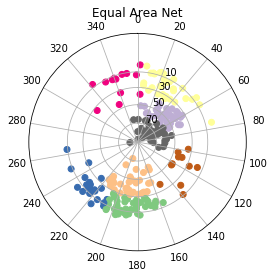

In [34]:
kmeans = KMeans() #unspecified number of clusters
input_data=np.array([u,v,w]).transpose()
fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers,cmap='Accent')

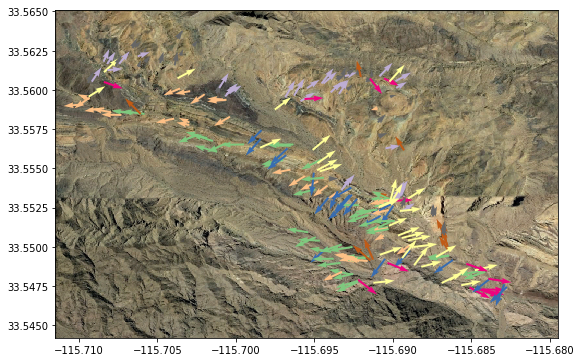

In [35]:
extent = [-115.7115, -115.6795, 33.5442, 33.5651]
img = plt.imread('Datasets/GoogleEarthImage.png')
plt.figure(figsize=(9,13))
plt.imshow(img, origin='upper', extent=extent)
plt.quiver(poles_data.Lon,poles_data.Lat,u,v,clusternumbers,cmap='Accent');

Lesson learned:  unsupervised does not mean just letting **scikit-learn** loose with no guidance!  Look at the data and provide some intellegient boundaries.  

Next lecture, we will continue to use **scikit-learn**, by doing some _supervised_ learning and moving on to some more complicated examples.

### Assignment \#8



The Christmas Day Earthquake, in 2016, was a magnitude 7.6 earthquake, so it was observed by  seismic stations around the world.

In previous weeks, we looked at a seismic record from a single station, Pinyon Flat and used that record to estimate the P-wave arrival, S-wave arrival, and the distance between the station and the earthquake epicenter.

In this assignment, we will calculate: the S-wave and P-wave arrivals at 4 different stations, the great circle distance between each station and the earthquake epicenter, and find the coordinates of the epicenter.


The four stations are **HOPE, PAYG, PMSA, and SJG**. The data from these stations were downloaded from the IRIS website: 
 http://ds.iris.edu/wilber3/find_stations/9948944
 

You'll find the datafiles in the folder _Datasets/seismicRecords/_  (which may be in a folder 'above' the current working directory). 



Each file has either HOPE, PAYG, PMSA or SJG in the filename. These are the different stations we wish to analyze.


1. The seismic records are in the files with the extension _.txt_ 
    
    a. Read each datafile into a pandas DataFrame. The actual data start after a  meta-data line so use skiprows=1, header=None
    
    b.   Make a figure object with  the **fig=plt.figure()** statement using the **figsize** argument to set the figure to be 10x10.  Use the **ax=fig.add_subplots()** syntax to create axis objects (ax1-ax4) with 4 rows and one column. Plot a seismogram from each station.  Put a note on each  seismogram using the **plt.text(x,y,stationName,transform=ax.transAxes)** syntax, where stationName is one of the station names.  Here **ax** should be one of your axis objects and x and y are the locations in relative coordinates for your note (0 is far left (bottom) and 1 is far right(top).  

2. Write a function to calculate the time delay for a given seismic record:
   
   a. Find the P wave arrival
       i.  Assume a sampling rate of 20 samples/second.  You can find this information in the file headers, e.g., '20 sps'.
       
       ii. Filter for the first .8 minutes and label it noise
       
       iii. Calculate the maximum value and minimum value in the noise 
       
       iii. Find the first velocity  after .8 minutes that is greater than the maximum noise or is less than the minimum noise. Take this as  the P-wave arrival.  Take the last peak that exceeds the noise limits as the S-wave arrival.  
       
    b. Calculate the time delay between the S wave arrival and the P wave arrival using your function.
    
   c. Use the time delay to find the great circle distance (in degrees) between the station and the earthquake epicenter 
   (**Hint:** use the file _DeltaTimeData.csv_ in the _Datasets_ directory  used in earlier lectures.)

3. Make a map
    
    a. Use the files in the Datasets/seismicRecords directory with the extension .BHZ to get the latitude and longitude of each station
    
    b. Plot each station on the map as a star
    
    c. For each station, use the function **pts_on_a_plane( )** from Lecture 23, the coordinates of the station as the pole, and the great circle distance you calculated in 2c as gamma to find the points on a small circle
   
   d. Plot the small circle around each station
   e. The small circles should all intersect where the Earthquake occured- in Chile, so plot the location of the Earthquake (from Lecture 6, latitude=-43.42, longitude=-73.95) as a blue square.  How did we do?  
    
